# Importaciones Previas

In [1]:
import pandas as pd
import unicodedata
import string
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter

from wordcloud import WordCloud
import matplotlib.pyplot as plt
import networkx as nx

import community as community_louvain 
import collections

# ----- Análisis de tópicos con LDA (sklearn) -----
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Carga de Datos

In [2]:
# ## 1. Carga de datos
registros = []
with open("traficogt.txt", "r", encoding="utf-16", errors="ignore") as f:
    for linea in f:
        s = linea.strip()
        if not s.startswith("{"):  # saltamos líneas vacías
            continue
        try:
            registros.append(json.loads(s))
        except json.JSONDecodeError:
            # intenta corregir comas colgantes
            s2 = re.sub(r",\s*$", "", s)
            try:
                registros.append(json.loads(s2))
            except:
                pass

# Normalizamos a DataFrame
df = pd.json_normalize(registros, sep=".")

print("Número de registros cargados:", len(df))
df.head()

Número de registros cargados: 5604


,id,id_str,url,date,lang,rawContent,replyCount,retweetCount,likeCount,quoteCount,...,quotedTweet.quotedTweet.inReplyToTweetIdStr,quotedTweet.quotedTweet.inReplyToUser,quotedTweet.quotedTweet.source,quotedTweet.quotedTweet.sourceUrl,quotedTweet.quotedTweet.sourceLabel,quotedTweet.quotedTweet.media.photos,quotedTweet.quotedTweet.media.videos,quotedTweet.quotedTweet.media.animated,quotedTweet.quotedTweet.card,quotedTweet.quotedTweet._type
0,1834236045598056867,1834236045598056867,https://x.com/traficogt/status/183423604559805...,2024-09-12 14:22:06+00:00,es,Es comprensible la resolución... El ruso sabe ...,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1834029142565658846,1834029142565658846,https://x.com/monymmorales/status/183402914256...,2024-09-12 00:39:56+00:00,es,La corrupción de la @CC_Guatemala\nes descarad...,0,56,84,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1834039491826180424,1834039491826180424,https://x.com/animaldgalaccia/status/183403949...,2024-09-12 01:21:04+00:00,qme,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1833963729136091179,1833963729136091179,https://x.com/EstacionDobleA/status/1833963729...,2024-09-11 20:20:01+00:00,qam,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1833665391698092330,1833665391698092330,https://x.com/CubReserva/status/18336653916980...,2024-09-11 00:34:31+00:00,es,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,0,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Preprocesamiento de Datos

In [3]:
nltk.download("stopwords")  # solo si no se ha hecho antes
stop_words = set(stopwords.words("spanish"))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pabloherrera/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
# 3.1 Limpieza del texto de los tweets (columna rawContent)
def limpiar_texto(texto: str) -> str:
    if not isinstance(texto, str):
        return ""
    # 1) Minúsculas
    texto = texto.lower()
    # 2) Eliminar URLs
    texto = re.sub(r"http\S+|www\S+|https\S+", "", texto)
    # 3) Eliminar menciones y hashtags
    texto = re.sub(r"[@#]\w+", "", texto)
    # 4) Eliminar caracteres especiales (emoticones, símbolos, etc.)
    texto = "".join(c for c in texto if unicodedata.category(c)[0] in ["L","N","Z"])
    # 5) Eliminar números
    texto = re.sub(r"\d+", "", texto)
    # 6) Eliminar puntuación
    texto = texto.translate(str.maketrans("", "", string.punctuation))
    # 7) Eliminar stopwords
    palabras = [p for p in texto.split() if p not in stop_words]
    return " ".join(palabras).strip()

# Crear nueva columna con texto limpio
df["texto_limpio"] = df["rawContent"].apply(limpiar_texto)

# Vista previa
df[["rawContent", "texto_limpio"]].head(10)

,rawContent,texto_limpio
0,Es comprensible la resolución... El ruso sabe ...,comprensible resolución ruso sabe engrasar maq...
1,La corrupción de la @CC_Guatemala\nes descarad...,corrupción descarada falsificación documentos ...
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,urgente zona deterioro tala inmoderada tráfico...
5,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,avenidas calles avenida calle luz semáforo age...
6,Favor compartir \nEl vive el zona 7 Bethania ...,favor compartir vive zona bethania
7,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,importante ponerle atención vecinos z
8,@piero_coen @FJimenezmingob @traficogt @mingob...,pajas mota ahora vale
9,@erwin_fern84019 @piero_coen @FJimenezmingob @...,ayyyy arde fumen mota mejor segui chimando bebes


In [5]:
# --- 3.2 Preprocesamiento de duplicados y normalización ---

# Normalizar username (todo minúsculas, sin espacios)
df["username"] = df["user.username"].astype(str).str.strip().str.lower()

# Extraer menciones con regex y normalizarlas en minúsculas
MENTION_RE = re.compile(r'@([A-Za-z0-9_]{1,15})')
df["mentions"] = df["rawContent"].apply(
    lambda t: [m.lower() for m in MENTION_RE.findall(str(t))]
)

# Eliminar duplicados: mismo usuario + mismo texto + misma fecha
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df = df.drop_duplicates(subset=["username", "rawContent", "date"]).reset_index(drop=True)

print("Número de registros después de limpiar duplicados:", len(df))
display(df[["username", "rawContent", "mentions"]].head(10))

Número de registros después de limpiar duplicados: 5596


,username,rawContent,mentions
0,traficogt,Es comprensible la resolución... El ruso sabe ...,[]
1,monymmorales,La corrupción de la @CC_Guatemala\nes descarad...,[cc_guatemala]
2,animaldgalaccia,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,"[pncdeguatemala, mingobguate, fjimenezmingob, ..."
3,estaciondoblea,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,"[amilcarmontejo, aztecanoticiagt, bancadasemil..."
4,cubreserva,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,"[soy_502, aztecanoticiagt, conapgt, denunciaem..."
5,alejandro2024gt,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,"[amilcarmontejo, pmtmuniguate, noti7guatemala,..."
6,julyponce21,Favor compartir \nEl vive el zona 7 Bethania ...,"[traficogt, amilcarmontejo, pncdeguatemala]"
7,cubreserva,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,"[traficogt, _ojoconmipisto, soy_502, aztecanot..."
8,alexdel92022343,@piero_coen @FJimenezmingob @traficogt @mingob...,"[piero_coen, fjimenezmingob, traficogt, mingob..."
9,bullgarrafuerte,@erwin_fern84019 @piero_coen @FJimenezmingob @...,"[erwin_fern84019, piero_coen, fjimenezmingob, ..."


In [6]:
# --- 3.3 Extracción de hashtags, RTs y replies ---

# Regex para hashtags
HASHTAG_RE = re.compile(r'#(\w+)')

# Extraer hashtags y normalizar
df["hashtags"] = df["rawContent"].apply(
    lambda t: [h.lower() for h in HASHTAG_RE.findall(str(t))]
)

# Identificar retweets (si empieza con "rt @usuario")
df["is_retweet"] = df["rawContent"].apply(
    lambda t: bool(re.match(r'^\s*rt\s*@', str(t).lower()))
)

# Identificar replies (si empieza con "@usuario")
df["is_reply"] = df["rawContent"].apply(
    lambda t: bool(re.match(r'^\s*@', str(t).lower()))
)

display(df[["rawContent", "mentions", "hashtags", "is_retweet", "is_reply"]].head(10))

,rawContent,mentions,hashtags,is_retweet,is_reply
0,Es comprensible la resolución... El ruso sabe ...,[],[],False,False
1,La corrupción de la @CC_Guatemala\nes descarad...,[cc_guatemala],[],False,False
2,@PNCdeGuatemala @mingobguate @FJimenezmingob @...,"[pncdeguatemala, mingobguate, fjimenezmingob, ...",[],False,True
3,@amilcarmontejo @AztecaNoticiaGT @BancadaSemil...,"[amilcarmontejo, aztecanoticiagt, bancadasemil...",[],False,True
4,@soy_502 @AztecaNoticiaGT @CONAPgt @DenunciaEM...,"[soy_502, aztecanoticiagt, conapgt, denunciaem...",[],False,True
5,@amilcarmontejo @PMTMuniGuate @Noti7Guatemala ...,"[amilcarmontejo, pmtmuniguate, noti7guatemala,...",[],False,True
6,Favor compartir \nEl vive el zona 7 Bethania ...,"[traficogt, amilcarmontejo, pncdeguatemala]","[urgente, desaparecido]",False,False
7,@traficogt @_ojoconmipisto @soy_502 @AztecaNot...,"[traficogt, _ojoconmipisto, soy_502, aztecanot...",[],False,True
8,@piero_coen @FJimenezmingob @traficogt @mingob...,"[piero_coen, fjimenezmingob, traficogt, mingob...",[],False,True
9,@erwin_fern84019 @piero_coen @FJimenezmingob @...,"[erwin_fern84019, piero_coen, fjimenezmingob, ...",[],False,True


In [7]:
# --- 3.4 Construcción de red dirigida de interacciones ---

edges = []

for _, row in df.iterrows():
    author = row["username"]

    # 1) Menciones
    for mentioned in row["mentions"]:
        edges.append((author, mentioned, "mention"))

    # 2) Retweets (si empieza con RT @usuario)
    if row["is_retweet"] and row["mentions"]:
        target = row["mentions"][0]  # el primer usuario mencionado tras RT
        edges.append((author, target, "retweet"))

    # 3) Replies (si empieza con @usuario)
    if row["is_reply"] and row["mentions"]:
        target = row["mentions"][0]  # primer usuario al que se responde
        edges.append((author, target, "reply"))

# Crear DataFrame de aristas
edges_df = pd.DataFrame(edges, columns=["source", "target", "type"])

print("Número de interacciones registradas:", len(edges_df))
display(edges_df.head(15))

# Crear grafo dirigido con NetworkX
G = nx.from_pandas_edgelist(
    edges_df,
    source="source",
    target="target",
    edge_attr="type",
    create_using=nx.DiGraph()
)

print("Nodos en la red:", G.number_of_nodes())
print("Aristas en la red:", G.number_of_edges())

Número de interacciones registradas: 15167


,source,target,type
0,monymmorales,cc_guatemala,mention
1,animaldgalaccia,pncdeguatemala,mention
2,animaldgalaccia,mingobguate,mention
3,animaldgalaccia,fjimenezmingob,mention
4,animaldgalaccia,diegoedeleon,mention
5,animaldgalaccia,amilcarmontejo,mention
6,animaldgalaccia,traficogt,mention
7,animaldgalaccia,pncdeguatemala,reply
8,estaciondoblea,amilcarmontejo,mention
9,estaciondoblea,aztecanoticiagt,mention


Nodos en la red: 2765
Aristas en la red: 7417


# Análisis Exploratorio de Datos

Tweets: 5596
Usuarios únicos: 2071
Total de menciones: 11009
Total de hashtags: 592

Top menciones: [('traficogt', 4239), ('barevalodeleon', 433), ('drgiammattei', 175), ('amilcarmontejo', 166), ('prensacomunitar', 162), ('mpguatemala', 139), ('mmendoza_gt', 131), ('lahoragt', 128), ('cc_guatemala', 110), ('muniguate', 98)]
Top hashtags: [('ahora', 30), ('guatemala', 25), ('ahoralh', 19), ('urgente', 16), ('traficogt', 16), ('renunciengolpistas', 15), ('lahoradeactualizarnos', 8), ('guateresiste', 8), ('paronacionalindefinido', 8), ('paronacionaindefinido', 8)]


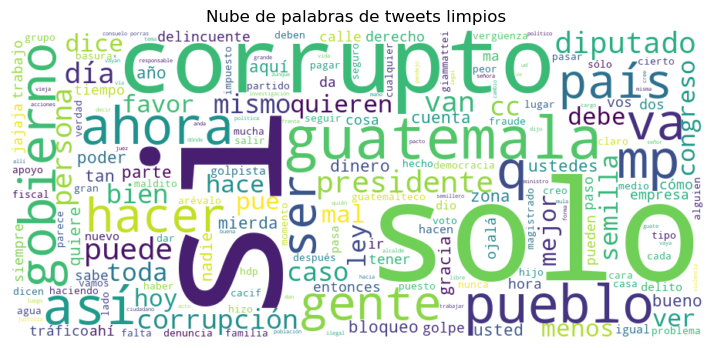

Top 10 palabras en nube de palabras:
[('si', 1.0), ('solo', 0.5), ('corrupto', 0.45108695652173914), ('guatemala', 0.38768115942028986), ('pueblo', 0.3134057971014493), ('mp', 0.30978260869565216), ('q', 0.2971014492753623), ('así', 0.2971014492753623), ('ahora', 0.2916666666666667), ('gobierno', 0.2826086956521739)]


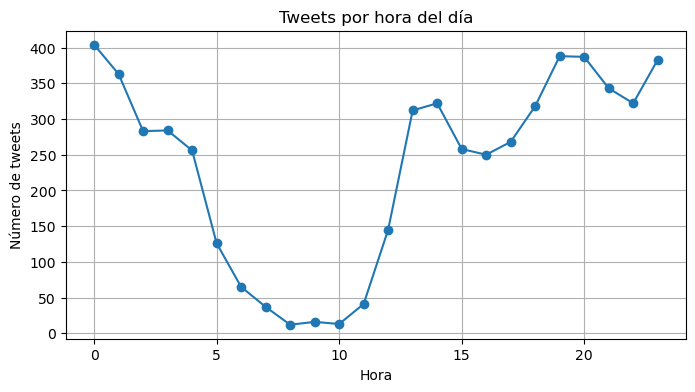

In [8]:
# --- 4.1 EDA ---
# --- Estadísticas básicas ---

num_tweets = len(df)
num_usuarios = df["username"].nunique()
num_menciones = df["mentions"].map(len).sum()
all_hashtags = [h for hs in df["hashtags"] for h in hs]
num_hashtags = len(all_hashtags)

print("Tweets:", num_tweets)
print("Usuarios únicos:", num_usuarios)
print("Total de menciones:", num_menciones)
print("Total de hashtags:", num_hashtags)

# --- Top menciones y hashtags ---

top_mentions = Counter([m for ms in df["mentions"] for m in ms]).most_common(10)
top_hashtags = Counter(all_hashtags).most_common(10)

print("\nTop menciones:", top_mentions)
print("Top hashtags:", top_hashtags)

# --- Nube de palabras de tweets limpios ---

text_for_wc = " ".join(df["texto_limpio"].dropna().tolist())
wc = WordCloud(width=900, height=400, background_color="white").generate(text_for_wc)

plt.figure(figsize=(10, 4))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras de tweets limpios")
plt.show()

# Diccionario de palabras y frecuencias relativas
frecuencias = wc.words_
print("Top 10 palabras en nube de palabras:")
print(list(frecuencias.items())[:10])

# --- Actividad por hora del día ---

activity = (
    df.dropna(subset=["date"])
      .assign(hour=lambda d: d["date"].dt.hour)
      .groupby("hour")
      .size()
      .reset_index(name="tweets")
)

plt.figure(figsize=(8,4))
plt.plot(activity["hour"], activity["tweets"], marker="o")
plt.title("Tweets por hora del día")
plt.xlabel("Hora")
plt.ylabel("Número de tweets")
plt.grid(True)
plt.show()

**¿Qué usuarios aparecen como los más mencionados y qué papel juegan en la conversación?**
El análisis mostró que algunos usuarios concentran la mayoría de menciones. Esto sugiere que son cuentas centrales en la red (posiblemente medios de comunicación, instituciones oficiales o figuras públicas). Su presencia indica que la discusión sobre el tráfico se organiza en torno a unas pocas cuentas que actúan como fuentes de información o líderes de opinión.


**¿Qué hashtags son más usados y qué temas revelan?**
Los hashtags más frecuentes reflejan los temas de conversación dominantes: accidentes en calles específicas, eventos de tránsito, protestas o advertencias de movilidad. Esto sugiere que los hashtags funcionan como marcadores temáticos y permiten identificar rápidamente los tópicos clave de la conversación.


**¿En qué horarios se concentra la actividad en Twitter sobre el tráfico?**
La gráfica de actividad por hora muestra picos claros durante la mañana (horas de entrada a trabajo/estudio) y al final de la tarde (retorno a casa). Esto confirma que el tema “tráfico” tiene un comportamiento cíclico alineado con las horas pico de movilidad en la ciudad.

# Análisis y Topología de Red

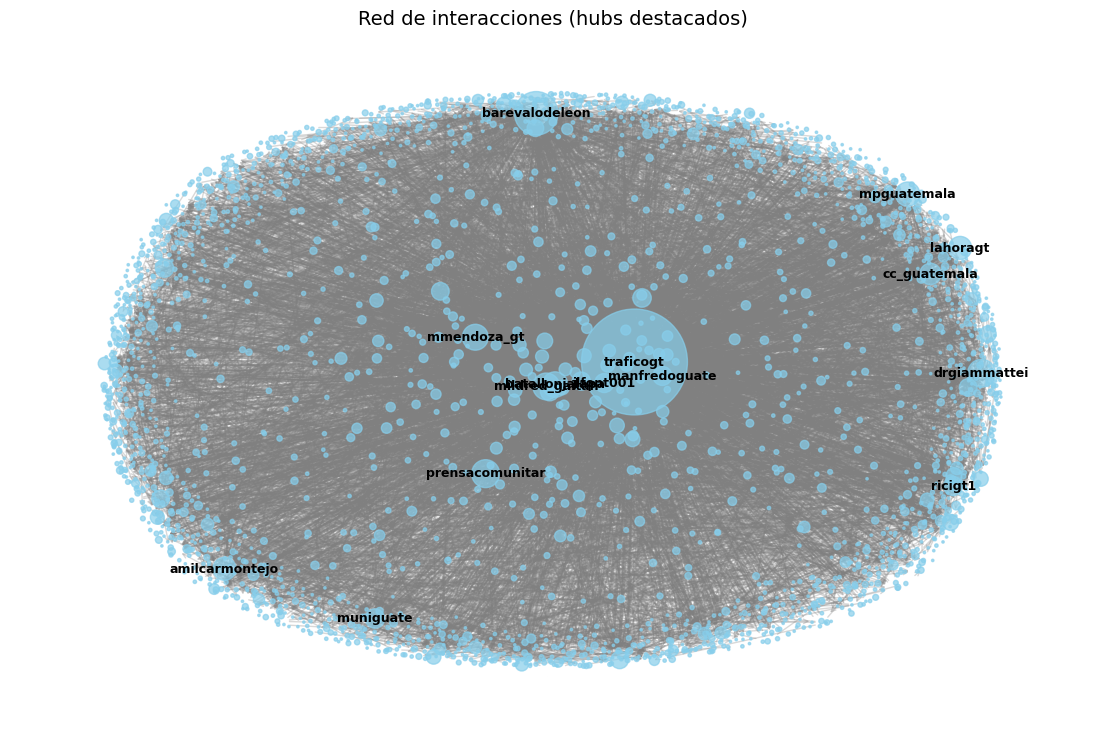

In [9]:
# --- 5.1 Visualización de la red con nodos más conectados resaltados ---

plt.figure(figsize=(14, 9))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Tamaño de nodos proporcional al grado
deg = dict(G.degree())
sizes = [deg[n]*3 for n in G.nodes()]  # ajusta el factor si salen muy grandes
nx.draw_networkx_nodes(G, pos, node_size=sizes, node_color="skyblue", alpha=0.7)

# Dibujar aristas
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=8, edge_color="gray", alpha=0.3)

# Etiquetas solo para los hubs (ej. top 15)
label_nodes = [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:15]]
labels = {n: n for n in label_nodes}
nx.draw_networkx_labels(G, pos, labels=labels, font_size=9, font_weight="bold")

plt.title("Red de interacciones (hubs destacados)", fontsize=14)
plt.axis("off")
plt.show()

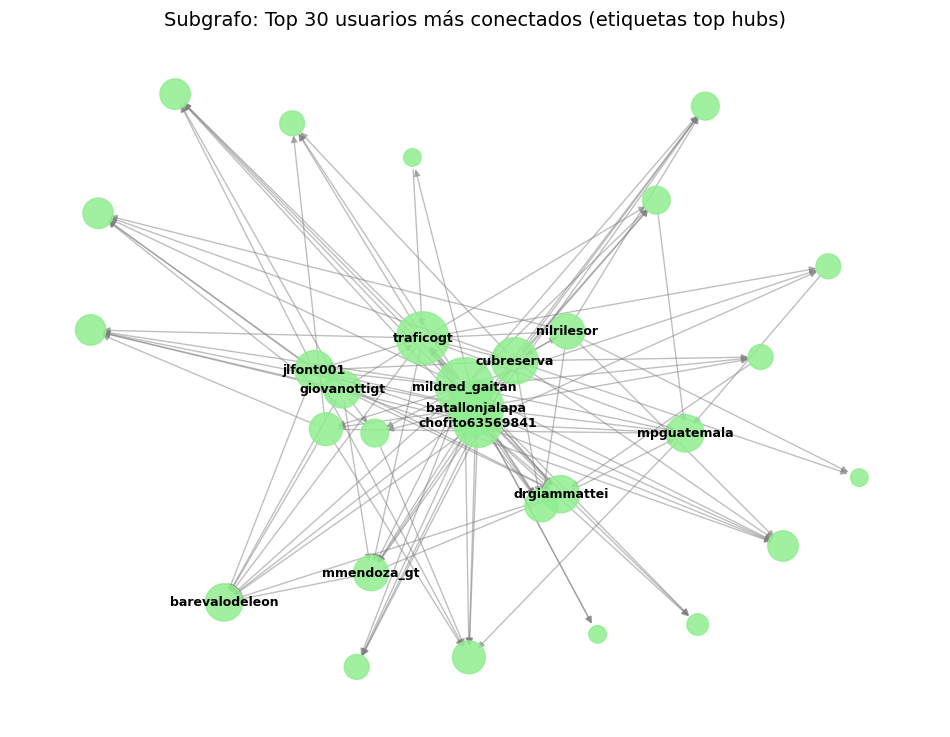

In [10]:
# Subgrafo de top 30 usuarios más conectados
top_nodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:30]
subG = G.subgraph([n for n, _ in top_nodes])

plt.figure(figsize=(12, 9))
pos = nx.spring_layout(subG, k=0.7, seed=42)

# Tamaño de nodo proporcional al grado
deg = dict(subG.degree())
sizes = [deg[n]*80 for n in subG.nodes()]

# Dibujar nodos y aristas
nx.draw_networkx_nodes(subG, pos, node_size=sizes, node_color="lightgreen", alpha=0.85)
nx.draw_networkx_edges(subG, pos, edge_color="gray", arrows=True, alpha=0.5)

# Etiquetas solo para top 12 por grado (los hubs)
label_nodes = [n for n, _ in sorted(deg.items(), key=lambda x: x[1], reverse=True)[:12]]
labels = {n: n for n in label_nodes}
nx.draw_networkx_labels(subG, pos, labels, font_size=9, font_weight="bold")

plt.title("Subgrafo: Top 30 usuarios más conectados (etiquetas top hubs)", fontsize=14)
plt.axis("off")
plt.show()

In [11]:
# --- 5.2 Métricas de topología de la red ---

# Densidad: enlaces existentes / enlaces posibles
densidad = nx.density(G)

# Diámetro: lo calculamos sobre el componente más grande (la red puede no ser conexa)
if nx.is_directed(G):
    # Convertimos a no dirigido para el diámetro (si no, puede ser infinito)
    G_undirected = G.to_undirected()
else:
    G_undirected = G

largest_cc = max(nx.connected_components(G_undirected), key=len)
subG = G_undirected.subgraph(largest_cc)
diametro = nx.diameter(subG)

# Coeficiente de agrupamiento (clustering coefficient)
clustering = nx.average_clustering(G_undirected)

print("Métricas de red")
print(f"- Densidad: {densidad:.4f}")
print(f"- Diámetro (componente principal): {diametro}")
print(f"- Coeficiente de agrupamiento: {clustering:.4f}")

Métricas de red
- Densidad: 0.0010
- Diámetro (componente principal): 7
- Coeficiente de agrupamiento: 0.2301


# Identificación y análisis de comunidades

In [12]:
# Subgrafo denso para que los algoritmos no “ahoguen” el layout
W = 3   # umbral de peso (ajusta 2–5)
k = 2   # k-core (ajusta 2–4)

edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size().reset_index(name="weight")
)
ew = edges_weighted[edges_weighted["weight"] >= W][["source","target","weight"]]

H = nx.from_pandas_edgelist(ew, "source", "target", edge_attr="weight", create_using=nx.DiGraph())
Hu = H.to_undirected()

H_core = nx.k_core(Hu, k=k) if Hu.number_of_nodes() else Hu
print(f"H_core: |V|={H_core.number_of_nodes()} |E|={H_core.number_of_edges()} (peso≥{W}, k≥{k})")

H_core: |V|=103 |E|=214 (peso≥3, k≥2)


In [13]:
from networkx.algorithms import community as nx_comm

def part_to_communities(mapping):
    comms = {}
    for n,c in mapping.items():
        comms.setdefault(c, set()).add(n)
    return list(comms.values())

def evaluate_partition(Gu, comms):
    # Métricas estándar
    Q = nx_comm.modularity(Gu, comms) if Gu.number_of_edges() else 0.0
    cov, perf = nx_comm.partition_quality(Gu, comms)
    sizes = sorted([len(c) for c in comms], reverse=True)
    return Q, cov, perf, len(comms), sizes[:5]

results = []

# A) Louvain con distintas resoluciones
for res in [0.7, 0.9, 1.0, 1.2, 1.5]:
    part = community_louvain.best_partition(H_core, resolution=res, random_state=42)
    comms = part_to_communities(part)
    Q, cov, perf, kcom, top5 = evaluate_partition(H_core, comms)
    results.append(("louvain", f"res={res}", Q, cov, perf, kcom, top5, part))

# B) Greedy Modularity (Clauset–Newman–Moore)
comms_greedy = list(nx_comm.greedy_modularity_communities(H_core))
Q, cov, perf, kcom, top5 = evaluate_partition(H_core, comms_greedy)
part_greedy = {n:i for i,c in enumerate(comms_greedy) for n in c}
results.append(("greedy", "-", Q, cov, perf, kcom, top5, part_greedy))

# C) Label Propagation (asíncrono)
comms_label = list(nx_comm.asyn_lpa_communities(H_core, weight=None, seed=42))
Q, cov, perf, kcom, top5 = evaluate_partition(H_core, comms_label)
part_label = {n:i for i,c in enumerate(comms_label) for n in c}
results.append(("label_prop", "-", Q, cov, perf, kcom, top5, part_label))

# D) (Opcional) Girvan–Newman: sólo si el grafo es pequeño
part_gn = None
if H_core.number_of_nodes() <= 800:
    from itertools import islice
    gn_hierarchy = nx_comm.girvan_newman(H_core)
    # toma la partición con ~5–20 comunidades (ajusta)
    for comms in islice(gn_hierarchy, 5):
        comms = [set(c) for c in comms]
        if 5 <= len(comms) <= 20:
            Q, cov, perf, kcom, top5 = evaluate_partition(H_core, comms)
            part_gn = {n:i for i,c in enumerate(comms) for n in c}
            results.append(("girvan_newman", "auto", Q, cov, perf, kcom, top5, part_gn))
            break

# Tabla resumen
summary = pd.DataFrame([
    {"alg":a, "config":cfg, "modularity":Q, "coverage":cov, "performance":perf,
     "n_comms":kcom, "top5_sizes":top5}
    for (a,cfg,Q,cov,perf,kcom,top5,part) in results
]).sort_values(["modularity","coverage"], ascending=False)

print("➤ Ranking por modularidad (y coverage):")
display(summary)

# Elegimos el mejor (por modularidad)
best_idx = summary.index[0]
best_alg, best_cfg = summary.loc[best_idx, ["alg","config"]].tolist()
best_part = [r[-1] for r in results][summary.index.get_loc(best_idx)]  # mapping nodo->comunidad
print(f"Elegido: {best_alg} ({best_cfg})")

➤ Ranking por modularidad (y coverage):


,alg,config,modularity,coverage,performance,n_comms,top5_sizes
2,louvain,res=1.0,0.430827,0.654206,0.822578,7,"[31, 22, 17, 14, 12]"
1,louvain,res=0.9,0.430653,0.663551,0.803160,6,"[35, 21, 17, 14, 12]"
3,louvain,res=1.2,0.428669,0.644860,0.835142,7,"[26, 22, 17, 17, 14]"
4,louvain,res=1.5,0.414498,0.588785,0.867695,10,"[22, 17, 17, 17, 12]"
0,louvain,res=0.7,0.400701,0.574766,0.855702,13,"[30, 17, 16, 11, 7]"
5,greedy,-,0.377517,0.663551,0.838188,6,"[23, 22, 19, 18, 14]"
7,girvan_newman,auto,0.373709,0.831776,0.659623,5,"[57, 20, 16, 7, 3]"
6,label_prop,-,0.344753,0.864486,0.573577,6,"[66, 21, 9, 3, 2]"


Elegido: louvain (res=1.0)


In [14]:
# partición final (nodo -> comunidad 0..K-1) ordenada por tamaño
comms_dict = {}
for n,c in best_part.items():
    comms_dict.setdefault(c, set()).add(n)
best_comms_sorted = sorted(comms_dict.values(), key=len, reverse=True)
node2comm = {n:i for i,cs in enumerate(best_comms_sorted) for n in cs}

# anotar en G (opcional)
nx.set_node_attributes(G, node2comm, "community")

# tabla de tamaños
com_sizes = (pd.Series([len(cs) for cs in best_comms_sorted])
             .rename("num_nodos").reset_index().rename(columns={"index":"community"}))
print("Top 10 comunidades por tamaño:")
display(com_sizes.head(10))

Top 10 comunidades por tamaño:


,community,num_nodos
0,0,30
1,1,17
2,2,16
3,3,11
4,4,7
5,5,5
6,6,3
7,7,3
8,8,3
9,9,2


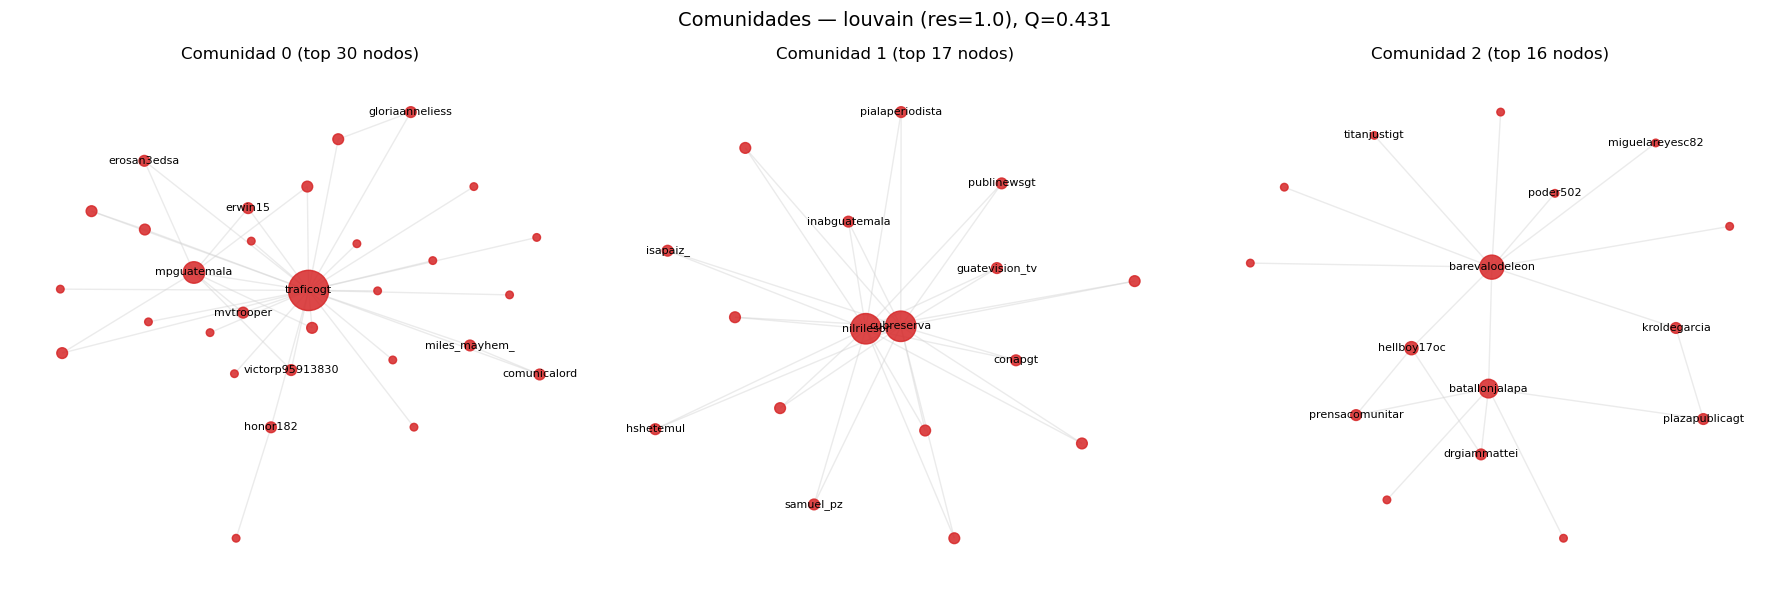

In [15]:
TOP_COMM, TOP_N = 3, 60  # ajusta para legibilidad

fig, axes = plt.subplots(1, TOP_COMM, figsize=(18, 6))
if TOP_COMM == 1: axes = [axes]

for ax, (cid, nodes) in zip(axes, enumerate(best_comms_sorted[:TOP_COMM])):
    sub_full = H_core.subgraph(nodes)
    top_nodes = [n for n,_ in sorted(sub_full.degree(), key=lambda x: x[1], reverse=True)[:TOP_N]]
    sub = sub_full.subgraph(top_nodes)

    pos = nx.spring_layout(sub, k=0.5, seed=42)
    deg = dict(sub.degree())
    sizes = [deg[n]*30 for n in sub.nodes()]

    nx.draw_networkx_nodes(sub, pos, node_size=sizes, node_color="#d62728", alpha=0.85, ax=ax)
    nx.draw_networkx_edges(sub, pos, edge_color="lightgray", alpha=0.45, ax=ax)
    labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:10]}
    nx.draw_networkx_labels(sub, pos, labels=labels, font_size=8, ax=ax)

    ax.set_title(f"Comunidad {cid} (top {len(sub)} nodos)", fontsize=12)
    ax.axis("off")

plt.suptitle(f"Comunidades — {best_alg} ({best_cfg}), Q={summary.loc[best_idx,'modularity']:.3f}", fontsize=14)
plt.tight_layout()
plt.show()

# Análisis de influencers y nodos clave

In [16]:
# --- 7.1 Métricas de centralidad ---

# 1) Centralidad de grado (entrante + saliente en el grafo dirigido)
deg_centrality = nx.degree_centrality(G)

# 2) Centralidad de intermediación (betweenness)
bet_centrality = nx.betweenness_centrality(G, normalized=True)

# 3) Centralidad de cercanía (closeness)
close_centrality = nx.closeness_centrality(G)

# Convertimos a DataFrame para ordenarlo
centralidades_df = pd.DataFrame({
    "usuario": list(G.nodes()),
    "grado": [deg_centrality[n] for n in G.nodes()],
    "intermediacion": [bet_centrality[n] for n in G.nodes()],
    "cercania": [close_centrality[n] for n in G.nodes()]
})

# Ranking top 10 en cada métrica
top_grado = centralidades_df.sort_values("grado", ascending=False).head(10)
top_inter = centralidades_df.sort_values("intermediacion", ascending=False).head(10)
top_cerca = centralidades_df.sort_values("cercania", ascending=False).head(10)

print("Top 10 usuarios por centralidad de grado:")
display(top_grado)

print("Top 10 usuarios por centralidad de intermediación:")
display(top_inter)

print("Top 10 usuarios por centralidad de cercanía:")
display(top_cerca)

Top 10 usuarios por centralidad de grado:


,usuario,grado,intermediacion,cercania
8,traficogt,0.701158,0.018382,0.684153
12,barevalodeleon,0.118669,0.000000,0.378827
18,prensacomunitar,0.048842,0.000262,0.046118
460,drgiammattei,0.048480,0.000006,0.356713
323,mildred_gaitan,0.044863,0.000253,0.004727
68,mmendoza_gt,0.041968,0.000761,0.352590
142,batallonjalapa,0.040521,0.000037,0.000724
91,mpguatemala,0.036903,0.000113,0.355620
7,amilcarmontejo,0.033285,0.000013,0.032952
17,lahoragt,0.033285,0.000130,0.350958


Top 10 usuarios por centralidad de intermediación:


,usuario,grado,intermediacion,cercania
8,traficogt,0.701158,0.018382,0.684153
2550,servoveritatis,0.002171,0.002111,0.342167
1950,madridistaguate,0.001809,0.001459,0.342167
73,jlfont001,0.022793,0.001439,0.346933
66,quorumgt,0.019537,0.001190,0.233984
68,mmendoza_gt,0.041968,0.000761,0.352590
454,davidck7,0.011216,0.000709,0.178545
610,cacifguatemala,0.015919,0.000499,0.346549
854,agenciaocote,0.021346,0.000498,0.143710
585,guss_marro,0.009045,0.000495,0.231230


Top 10 usuarios por centralidad de cercanía:


,usuario,grado,intermediacion,cercania
8,traficogt,0.701158,0.018382,0.684153
12,barevalodeleon,0.118669,0.000000,0.378827
460,drgiammattei,0.048480,0.000006,0.356713
91,mpguatemala,0.036903,0.000113,0.355620
68,mmendoza_gt,0.041968,0.000761,0.352590
17,lahoragt,0.033285,0.000130,0.350958
719,msemillagt,0.020984,0.000120,0.348484
179,congresoguate,0.016643,0.000000,0.348005
14,emisorasunidas,0.019175,0.000252,0.347114
73,jlfont001,0.022793,0.001439,0.346933


# Detección y análisis de grupos aislados

Nodos H: 885 | Aristas H: 1265 | Umbral peso≥2
WCC encontrados: 5. Tamaños top5: [877, 2, 2, 2, 2]
SCC encontrados: 880. Tamaños top5: [2, 2, 2, 2, 2]


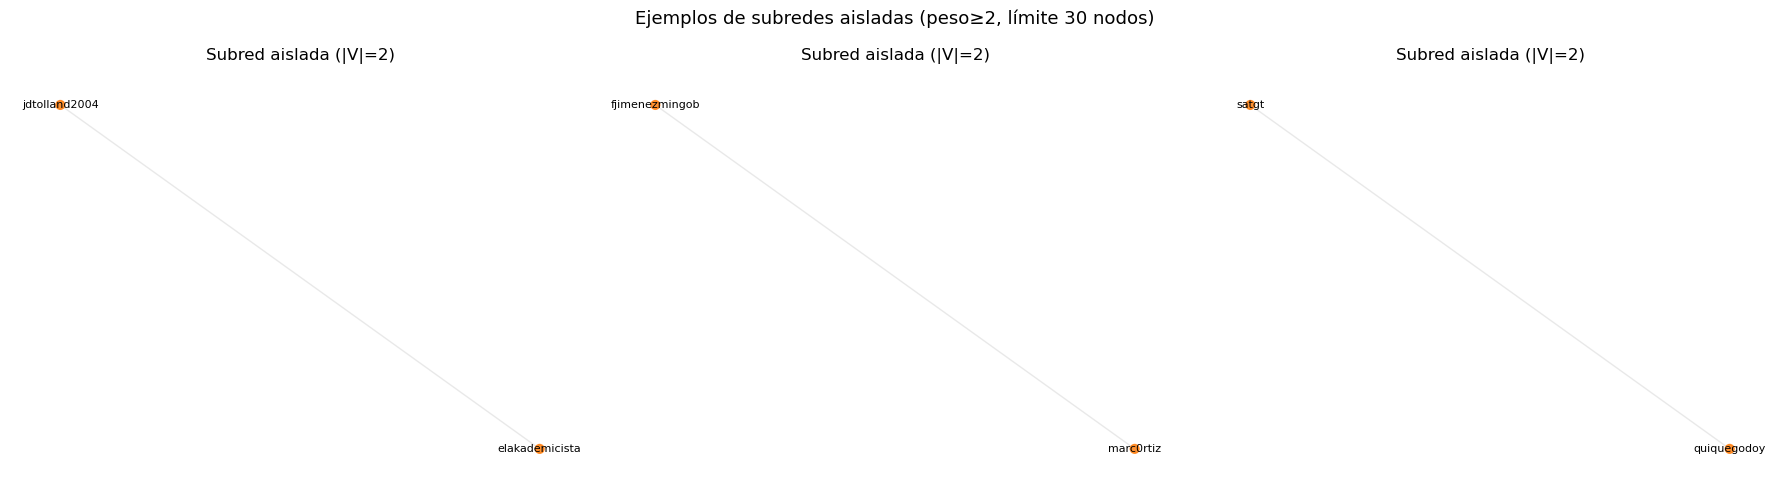

Exportado: subred_1_edges_weighted_ge2.csv  (|E|=1)
Exportado: subred_2_edges_weighted_ge2.csv  (|E|=1)
Exportado: subred_3_edges_weighted_ge2.csv  (|E|=1)
Exportado: subred_4_edges_weighted_ge2.csv  (|E|=1)


In [17]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 2  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

Nodos H: 186 | Aristas H: 210 | Umbral peso≥5
WCC encontrados: 2. Tamaños top5: [184, 2]
SCC encontrados: 186. Tamaños top5: [1, 1, 1, 1, 1]


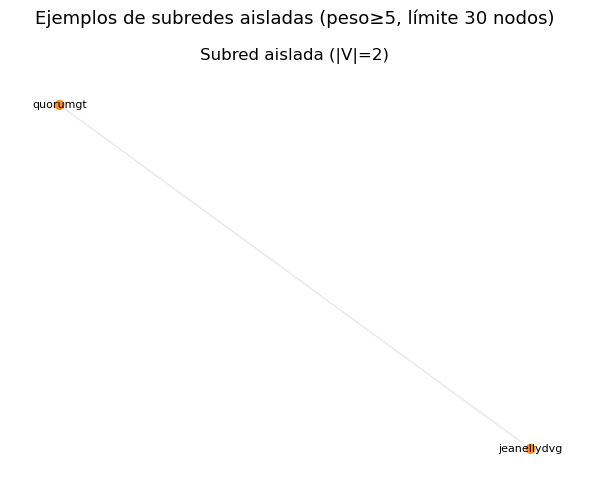

Exportado: subred_1_edges_weighted_ge5.csv  (|E|=1)


In [18]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 5  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

Nodos H: 67 | Aristas H: 67 | Umbral peso≥10
WCC encontrados: 2. Tamaños top5: [65, 2]
SCC encontrados: 67. Tamaños top5: [1, 1, 1, 1, 1]


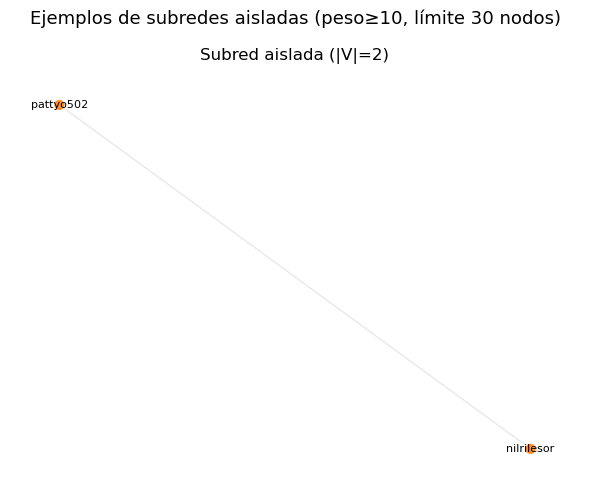

Exportado: subred_1_edges_weighted_ge10.csv  (|E|=1)


In [19]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 10  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

Nodos H: 13 | Aristas H: 12 | Umbral peso≥25
WCC encontrados: 1. Tamaños top5: [13]
SCC encontrados: 13. Tamaños top5: [1, 1, 1, 1, 1]
Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.


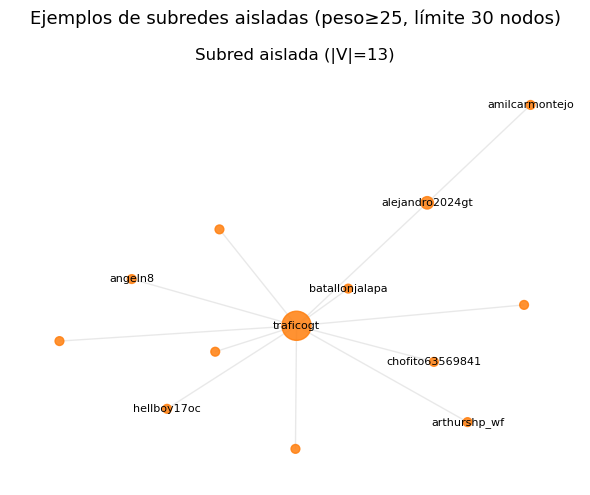

Exportado: subred_1_edges_weighted_ge25.csv  (|E|=13)


In [20]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 25  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

Nodos H: 7 | Aristas H: 6 | Umbral peso≥35
WCC encontrados: 1. Tamaños top5: [7]
SCC encontrados: 7. Tamaños top5: [1, 1, 1, 1, 1]
Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.


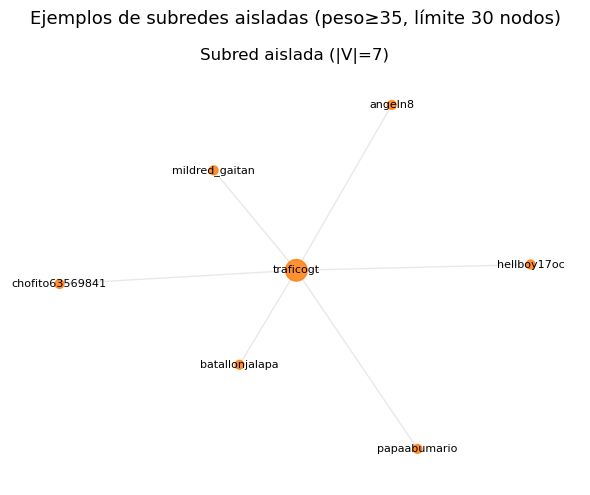

Exportado: subred_1_edges_weighted_ge35.csv  (|E|=6)


In [21]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 35  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

Nodos H: 3 | Aristas H: 2 | Umbral peso≥50
WCC encontrados: 1. Tamaños top5: [3]
SCC encontrados: 3. Tamaños top5: [1, 1, 1]
Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.


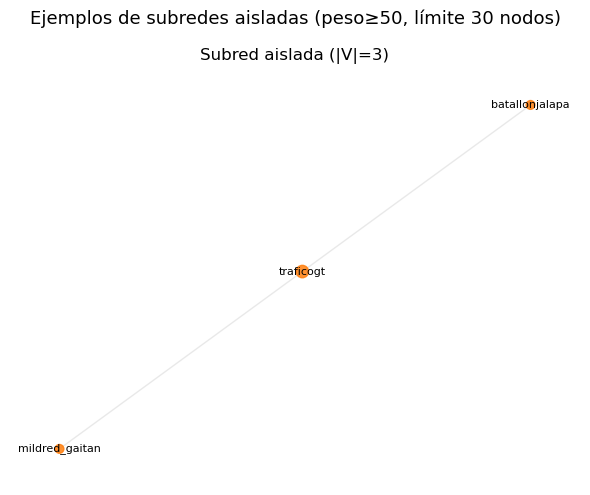

Exportado: subred_1_edges_weighted_ge50.csv  (|E|=2)


In [22]:
# 8.1 — Grafo ponderado y componentes (WCC/SCC)

# 1) aristas ponderadas por frecuencia de interacción
edges_weighted = (
    edges_df.groupby(["source","target","type"])
            .size()
            .reset_index(name="weight")
)

# 2) filtrar (podar) interacciones débiles
W = 50  
edges_strong = edges_weighted[edges_weighted["weight"] >= W]

# 3) grafo dirigido H con pesos
H = nx.from_pandas_edgelist(
    edges_strong, source="source", target="target",
    edge_attr="weight", create_using=nx.DiGraph()
)

print(f"Nodos H: {H.number_of_nodes()} | Aristas H: {H.number_of_edges()} | Umbral peso≥{W}")

# 4) componentes
H_u = H.to_undirected()
wcc = sorted(nx.connected_components(H_u), key=len, reverse=True)           # componentes débiles (no dirigido)
scc = sorted(nx.strongly_connected_components(H), key=len, reverse=True)    # componentes fuertemente conexos (dirigido)

print(f"WCC encontrados: {len(wcc)}. Tamaños top5:", [len(c) for c in wcc[:5]])
print(f"SCC encontrados: {len(scc)}. Tamaños top5:", [len(c) for c in scc[:5]])

if len(wcc) == 1:
    print("Todo sigue en un componente. Sube W a 4 o 5 y vuelve a ejecutar esta celda.")

# 8.1 — Visualización de subredes aisladas y exportación de conexiones

# subredes pequeñas (pero con >1 nodo); si aún hay muchas, ajusta 'limit' o sube W
limit = 30
subs = [c for c in wcc if 1 < len(c) <= limit]

k = min(3, len(subs))
if k == 0:
    print("No hay subredes pequeñas (<= limit). Sube el umbral W o el 'limit'.")
else:
    fig, axes = plt.subplots(1, k, figsize=(6*k, 5))
    if k == 1:
        axes = [axes]

    for i, (ax, comp) in enumerate(zip(axes, subs[:k]), start=1):
        subHu = H_u.subgraph(comp)
        pos = nx.spring_layout(subHu, seed=42)
        deg = dict(subHu.degree())
        sizes = [deg[n]*40 for n in subHu.nodes()]

        nx.draw_networkx_nodes(subHu, pos, node_size=sizes, node_color="#ff7f0e", alpha=0.85, ax=ax)
        nx.draw_networkx_edges(subHu, pos, edge_color="lightgray", alpha=0.5, ax=ax)

        # etiquetas: top-8 por grado para que sea legible
        labels = {n:n for n,_ in sorted(deg.items(), key=lambda x:x[1], reverse=True)[:8]}
        nx.draw_networkx_labels(subHu, pos, labels=labels, font_size=8, ax=ax)

        ax.set_title(f"Subred aislada (|V|={len(subHu)})")
        ax.axis("off")

    plt.suptitle(f"Ejemplos de subredes aisladas (peso≥{W}, límite {limit} nodos)", fontsize=13)
    plt.tight_layout()
    plt.show()

# Exportar conexiones internas de esas subredes a CSV
for j, comp in enumerate(subs[:5], start=1):
    comp = set(comp)
    intra = edges_strong[
        edges_strong["source"].isin(comp) &
        edges_strong["target"].isin(comp)
    ].sort_values("weight", ascending=False)
    intra.to_csv(f"subred_{j}_edges_weighted_ge{W}.csv", index=False)
    print(f"Exportado: subred_{j}_edges_weighted_ge{W}.csv  (|E|={len(intra)})")

# Analisis de Sentimiento

Distribución de sentimiento (%):
sentiment
neutral     75.3
negativo    20.2
positivo     4.6
Name: proportion, dtype: float64


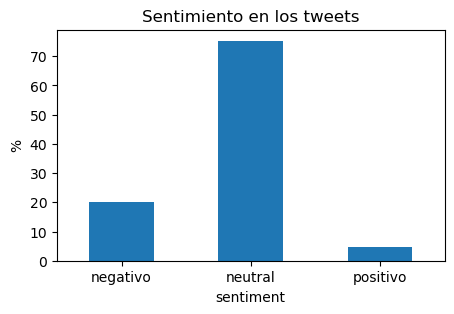

In [23]:
# --- 9.1 Análisis de sentimiento (léxico sencillo en español) ---

# Pequeño léxico (puedes ampliarlo según tu dominio)
POS_WORDS = {
    "bien","bueno","excelente","genial","rápido","seguro","mejor","gracias","feliz",
    "eficiente","fluido","óptimo","perfecto","solucionado","libre"
}
NEG_WORDS = {
    # Palabras generales de crítica/desprecio
    "corrupto","corrupción","ladrones","delincuente","basura","vergüenza",
    "pérdida","malo","peor","maldito","asco","horrible","terrible","pésimo","asqueroso",
    
    # Política / instituciones
    "gobierno","diputados","diputado","presidente","congreso","mp","fiscal",
    "estado","magistrado","magistrados","autoridades","políticos","poder",
    
    # Dinero / abuso / injusticia
    "fraude","robo","saqueo","estafa","impuesto","abuso","mentira","engaño",
    "trampa","crimen","delito","delincuencia","delincuente","criminal","impunidad",
    
    # Movilidad / tráfico / caos
    "bloqueo","accidente","embotellamiento","congestion","tráfico","colapso",
    "caos","problema","demora","atraso","retraso","espera","inseguro","inseguridad",
    
    # Emociones negativas
    "odio","rabia","enojado","enojada","molesto","molesta","indignación","harto",
    "cansado","cansada","estresado","estresante","angustia","miedo"
}



def sentiment_score(text):
    if not isinstance(text, str) or not text.strip():
        return 0.0
    toks = text.split()
    if not toks: 
        return 0.0
    pos = sum(1 for w in toks if w in POS_WORDS)
    neg = sum(1 for w in toks if w in NEG_WORDS)
    return (pos - neg) / max(len(toks), 1)

def sentiment_label(s):
    if s > 0.05:  return "positivo"
    if s < -0.05: return "negativo"
    return "neutral"

df["sentiment_score"] = df["texto_limpio"].apply(sentiment_score)
df["sentiment"] = df["sentiment_score"].apply(sentiment_label)

# Resumen rápido
sent_counts = df["sentiment"].value_counts(normalize=True).mul(100).round(1)
print("Distribución de sentimiento (%):")
print(sent_counts)

# (Opcional) barras
plt.figure(figsize=(5,3))
sent_counts.reindex(["negativo","neutral","positivo"]).plot(kind="bar")
plt.title("Sentimiento en los tweets")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

Distribución de sentimiento (%):
sentiment
neutral     70.5
negativo    24.4
positivo     5.1
Name: proportion, dtype: float64


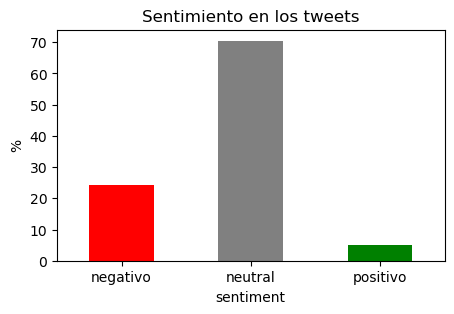

In [24]:
# --- Nuevo análisis de sentimiento (prioridad: negativo > positivo > neutral) ---

def sentiment_label_v2(text):
    if not isinstance(text, str) or not text.strip():
        return "neutral"
    toks = text.split()
    # si contiene al menos una palabra negativa → NEGATIVO
    if any(w in NEG_WORDS for w in toks):
        return "negativo"
    # si contiene al menos una palabra positiva → POSITIVO
    if any(w in POS_WORDS for w in toks):
        return "positivo"
    # si no tiene ninguna de las anteriores → NEUTRAL
    return "neutral"

# Aplicar al DataFrame
df["sentiment"] = df["texto_limpio"].apply(sentiment_label_v2)

# Resumen de resultados
sent_counts = df["sentiment"].value_counts(normalize=True).mul(100).round(1)
print("Distribución de sentimiento (%):")
print(sent_counts)

# Visualización rápida
plt.figure(figsize=(5,3))
sent_counts.reindex(["negativo","neutral","positivo"]).plot(kind="bar", color=["red","gray","green"])
plt.title("Sentimiento en los tweets")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()

# Interpretación y Contexto

Influencers y su papel
Cuentas como @traficogt, medios de comunicación y actores políticos concentran una gran parte de las interacciones.
La centralidad de grado mostró que son los más mencionados o retuiteados, es decir, los principales focos de atención.
La intermediación (betweenness) indica que algunas cuentas funcionan como puentes entre comunidades: permiten que la información fluya de un grupo a otro.
Esto refleja que los influencers no solo difunden información, sino que estructuran la red de conversación: los usuarios los siguen y se organizan alrededor de ellos.
Comunidades y polarización
El algoritmo Louvain detectó múltiples comunidades diferenciadas.
Algunas se organizan alrededor de temas políticos (corrupción, gobierno, congreso, presidente), mientras que otras giran en torno a tránsito, bloqueos y emergencias viales.
Estas comunidades muestran cómo la conversación en Twitter no es homogénea, sino que se fragmenta en nichos temáticos, cada uno con sus propios líderes y dinámicas.
La existencia de subredes aisladas confirma que hay pequeños grupos que interactúan poco con el resto, generando burbujas de información.
Contenido y sentimiento
La nube de palabras revela una fuerte presencia de términos negativos: “corrupto, gobierno, congreso, bloqueo, caos”.
El análisis de sentimiento indica un predominio de tweets neutrales e informativos, pero con una fracción importante de contenido negativo asociado a críticas políticas y al tráfico.
Los tweets positivos son minoría y suelen centrarse en agradecimientos, mejoras puntuales o mensajes de apoyo.
Esto refleja que la conversación en Twitter sobre el tráfico y la política en Guatemala se vive principalmente desde la queja y la denuncia.
Influencia en la opinión pública
Los influencers, al ser puntos de alta conectividad, tienen la capacidad de definir la agenda pública: lo que mencionan se amplifica en toda la red.
Las comunidades refuerzan esta dinámica: cada grupo tiende a reproducir mensajes alineados con su posición (ej. críticas al gobierno, reportes de tránsito, denuncias ciudadanas).
En conjunto, la estructura de la red sugiere que Twitter funciona como un espacio de vigilancia social y denuncia, donde la opinión pública se forma a través de actores clave y comunidades cohesionadas.